In [18]:
#|default_exp clustering
## Standard libraries
import os
import math
import numpy as np
import time
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
from diffusion_curvature.datasets import *
from diffusion_curvature.graphs import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
import jax
import jax.numpy as jnp
jax.devices()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1d Curvature Clustering

Our comparison space fitting is, unfortunately, too expensive to perform on every node of the graph. It presently take 10-20s to fit a comparison space; even if this were reduced 10 fold, a 5000 node graph would take over an hour.
Much of this computation would be redundant, as the spreads of diffusion of neighboring points change little, and they could easily reuse the same comparison space. Indeed, whole neighborhoods of the graph should be able to reuse the same comparison space. But what constitutes a neighborhood? And how do you ensure that the district lines don't divide up regions of homogenous curvature? Imagine, for example, two spheres joined by a sinuous bridge. Normal clustering algorithms would divide the bridge in half. We want the bridge to be in its own cluster.

To achieve this, we augment the well-known method of *spectral clustering* by supplementing its eigencoordinates with a new dimension: the unsigned curvature. 

In [19]:
#|export
from sklearn.cluster import KMeans
import jax.numpy as jnp
def enhanced_spectral_clustering(
        G, # PyGSP graph, or another with laplacian matrix L 
        ks, # unsigned magnitude of curvature
        dim, # intrinsic dimension of manifold (averaged across graph)
        num_clusters,
        curvature_weighting=1
        ):
    A = jnp.array(G.W)
    L = jnp.diag(jnp.sum(A,axis=1)) - A # D - A
    w, v = jnp.linalg.eigh(L) 
    X = v[:, 1:dim+1] # eigencoords
    # concatenate ks to X
    X = jnp.hstack((X, ks[:,None]))
    # normalize X by max min scaling
    X = (X - X.min(axis=0))/(X.max(axis=0) - X.min(axis=0))
    X = X.at[:,-1].set(curvature_weighting*X[:,-1])
    # perform knn clustering on X
    kmeans = KMeans(n_clusters=num_clusters).fit(X)
    return kmeans.labels_
    

In [21]:
from diffusion_curvature.core import get_adaptive_graph
X_torus, ks_torus = torus(5000)
G_torus = get_adaptive_graph(X_torus) #get_alpha_decay_graph(X_torus, knn=10, decay=20, anisotropy=0.5)

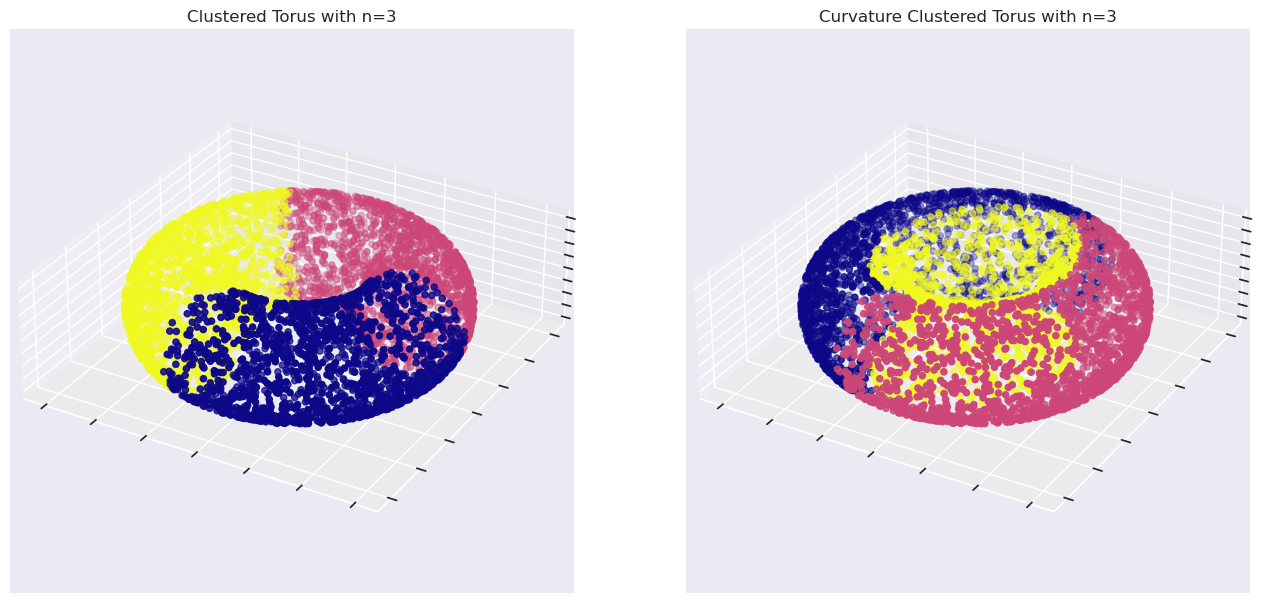

In [22]:
n=3
clusters = enhanced_spectral_clustering(G_torus, ks_torus, dim=2, num_clusters=n)
clusters_plain= enhanced_spectral_clustering(G_torus, ks_torus, dim=2, num_clusters=n, curvature_weighting=0)
fig = plt.figure(figsize=(16,8))

# plot the torus in 3D colored by its clustering
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_torus[:,0], X_torus[:,1], X_torus[:,2], c=clusters_plain, cmap='plasma')
ax1.set_title(f'Clustered Torus with n={n}')
ax1.set_box_aspect([np.ptp(X_torus[:,0]), np.ptp(X_torus[:,1]), np.ptp(X_torus[:,2])])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

# plot the torus in 3D colored by the curvature
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_torus[:,0], X_torus[:,1], X_torus[:,2], c=clusters, cmap='plasma')
ax2.set_title(f'Curvature Clustered Torus with n={n}')
ax2.set_box_aspect([np.ptp(X_torus[:,0]), np.ptp(X_torus[:,1]), np.ptp(X_torus[:,2])])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])

plt.show()

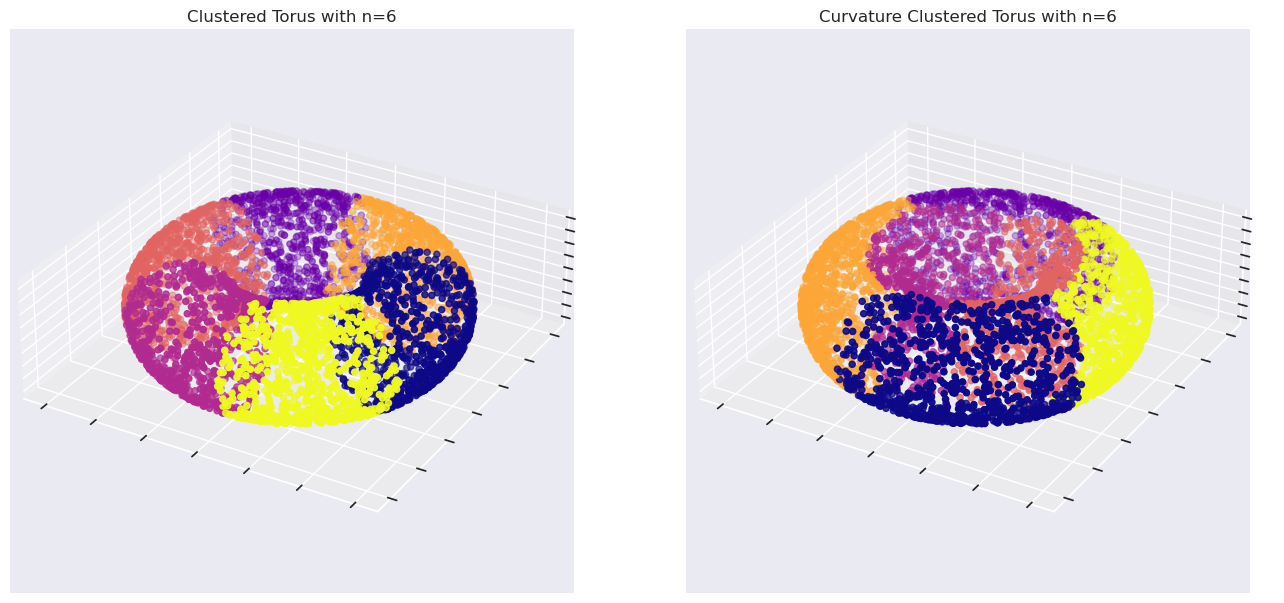

In [23]:
n=6
clusters= enhanced_spectral_clustering(G_torus, ks_torus, dim=2, num_clusters=n)
clusters_plain = enhanced_spectral_clustering(G_torus, ks_torus, dim=2, num_clusters=n, curvature_weighting=0)
fig = plt.figure(figsize=(16,8))

# plot the torus in 3D colored by its clustering
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_torus[:,0], X_torus[:,1], X_torus[:,2], c=clusters_plain, cmap='plasma')
ax1.set_title(f'Clustered Torus with n={n}')
ax1.set_box_aspect([np.ptp(X_torus[:,0]), np.ptp(X_torus[:,1]), np.ptp(X_torus[:,2])])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

# plot the torus in 3D colored by the curvature
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_torus[:,0], X_torus[:,1], X_torus[:,2], c=clusters, cmap='plasma')
ax2.set_title(f'Curvature Clustered Torus with n={n}')
ax2.set_box_aspect([np.ptp(X_torus[:,0]), np.ptp(X_torus[:,1]), np.ptp(X_torus[:,2])])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])

plt.show()

In [24]:
# array of all idxs in cluster i
cluster_idxs = [jnp.where(clusters==i)[0] for i in range(n)]

In [25]:
jnp.where(clusters==0)[0]

Array([   0,   11,   15,   27,   34,   38,   41,   47,   71,   73,   75,
         78,   81,   88,   90,   93,   99,  113,  115,  116,  122,  132,
        141,  146,  150,  151,  152,  156,  161,  173,  183,  184,  190,
        195,  196,  203,  223,  224,  238,  243,  244,  247,  264,  282,
        283,  292,  293,  308,  309,  312,  317,  328,  338,  339,  344,
        345,  352,  354,  357,  364,  367,  368,  371,  376,  377,  386,
        392,  394,  397,  405,  408,  409,  413,  418,  428,  434,  435,
        442,  443,  445,  455,  460,  466,  479,  481,  487,  488,  499,
        510,  514,  516,  533,  534,  537,  541,  555,  561,  574,  579,
        580,  587,  593,  595,  596,  598,  599,  603,  605,  607,  622,
        623,  631,  639,  654,  662,  665,  667,  672,  681,  687,  707,
        715,  725,  727,  730,  731,  732,  738,  745,  747,  750,  752,
        758,  763,  768,  777,  782,  786,  792,  795,  804,  811,  813,
        820,  822,  824,  838,  848,  851,  855,  8

In [27]:
!nbdev_export